In [1]:
import os 
print(os.listdir('../input'))

['brain-tumor-classification-mri']


In [2]:
import matplotlib.pyplot as plt 
import matplotlib.colors 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import cv2 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import layers 
from keras import ops
from keras.layers import Input , Dense , InputLayer , Flatten ,Conv2D , MaxPooling2D, Dropout 
from keras.models import Model , Sequential , load_model 
from tensorflow.keras.optimizers import Adam , SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau ,ModelCheckpoint 
from tqdm import tqdm 
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from imblearn.over_sampling import SMOTE 
from collections import Counter 
from sklearn.metrics import classification_report ,confusion_matrix ,ConfusionMatrixDisplay,accuracy_score
from PIL import Image 
from warnings import filterwarnings

2024-09-07 13:50:54.441374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 13:50:54.441490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 13:50:54.578137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train =[]
Y_train =[] 
image_size =150 
for i in labels : 
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        img = img / 255.0  # Normalize the image
        X_train.append(img) 
        Y_train.append(i)

for i in labels : 
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        img = img / 255.0  # Normalize the image
        X_train.append(img) 
        Y_train.append(i) 
X_train = np.array(X_train) 
Y_train = np.array(Y_train) 

100%|██████████| 74/74 [00:00<00:00, 125.45it/s]


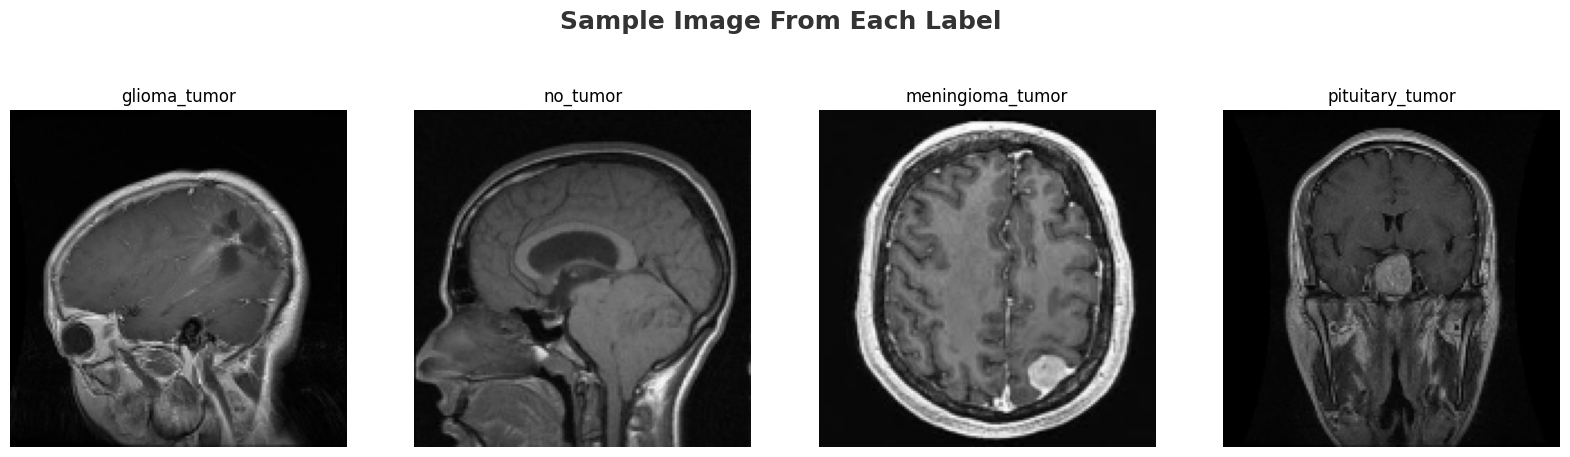

In [4]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if Y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(Y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [5]:
X_train , Y_train = shuffle(X_train ,Y_train,random_state=101)

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train, test_size=0.1,random_state=101)

In [7]:
label_encoder = LabelEncoder() 
y_train_num = label_encoder.fit_transform(Y_train)
y_test_num = label_encoder.fit_transform(Y_test)
Y_train = tf.keras.utils.to_categorical(y_train_num)
Y_test = tf.keras.utils.to_categorical(y_test_num)

In [8]:
n_samples, height, width, channels = X_train.shape

# Reshape X_train to (n_samples, height * width * channels)
X_train_reshaped = X_train.reshape(n_samples, -1)

smote = SMOTE()
X_resampled, Y_resampled = smote.fit_resample(X_train_reshaped, Y_train)

# reshape X_resampled back to the original dimensions
X_resampled = X_resampled.reshape(-1, height, width, channels)

print(X_resampled.shape)
print(Y_resampled.shape)

(3364, 150, 150, 3)
(3364, 4)


In [9]:
#  Y_train and Y_resampled are one-hot encoded:
Y_train_labels = np.argmax(Y_train, axis=1)
Y_resampled_labels = np.argmax(Y_resampled, axis=1)

# Count occurrences
train_class_counts = Counter(Y_train_labels)
resampled_class_counts = Counter(Y_resampled_labels)

print("Original training class distribution:", train_class_counts)
print("Resampled class distribution:", resampled_class_counts)

Original training class distribution: Counter({1: 841, 0: 833, 3: 814, 2: 449})
Resampled class distribution: Counter({0: 841, 2: 841, 3: 841, 1: 841})


# **Configure the hyperparameters**

In [10]:
input_shape = (150, 150, 3)
num_classes = 4
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100 
image_size = 150  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 48
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 10
mlp_head_units = [
    1024,
    512,
]  # Size of the dense layers of the final classifier

# **Implement multilayer perceptron (MLP)**

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# **Implement patch creation as a layer**

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

**Let's display patches for a sample image**

Image size: 150 X 150
Patch size: 16 X 16
Patches per image: 81
Elements per patch: 768


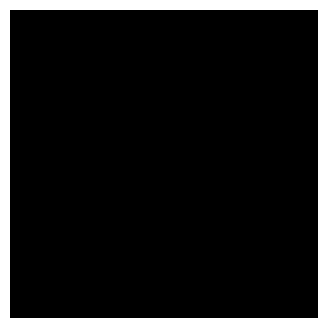

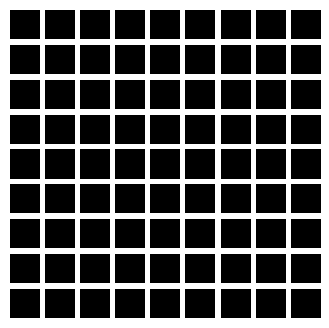

In [13]:
plt.figure(figsize=(4, 4))
image = X_resampled[np.random.choice(range(X_resampled.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

# **Implement the patch encoding layer**

In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

# **Build the ViT model**

In [15]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
   
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Initialize a learnable class token.
    class_token = tf.Variable(tf.zeros([1, 1, projection_dim]), trainable=True)

    # Use a Lambda layer to handle batch size and concatenate the class token.
    def add_class_token(encoded_patches):
        batch_size = tf.shape(encoded_patches)[0]
        class_tokens = tf.tile(class_token, [batch_size, 1, 1])
        return tf.concat([class_tokens, encoded_patches], axis=1)

    # Add the class token to the patches.
    encoded_patches_with_class = layers.Lambda(add_class_token)(encoded_patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches_with_class)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches_with_class])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches_with_class = layers.Add()([x3, x2])

    # Extract the class token after the Transformer layers.
    class_representation = encoded_patches_with_class[:, 0]

    # Continue with the final layers.
    representation = layers.LayerNormalization(epsilon=1e-6)(class_representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# **Compile, train, and evaluate the mode**

Epoch 1/100
 1/48 ━━━━━━━━━━━━━━━━━━━━ 1:12:28 93s/step - accuracy: 0.1562 - loss: 1.5050

I0000 00:00:1725717191.864130      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1725717191.929517      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2727 - loss: 1.4405  

W0000 00:00:1725717258.550999      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.2734 - loss: 1.4397 - val_accuracy: 0.6469 - val_loss: 1.1603 - learning_rate: 0.0010
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.4064 - loss: 1.2824 - val_accuracy: 0.5668 - val_loss: 1.1063 - learning_rate: 0.0010
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5484 - loss: 1.0989 - val_accuracy: 0.4125 - val_loss: 1.6130 - learning_rate: 0.0010
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.6177 - loss: 0.9259 - val_accuracy: 0.7953 - val_loss: 0.8276 - learning_rate: 0.0010
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6603 - loss: 0.8710 - val_accuracy: 0.5638 - val_loss: 1.3385 - learning_rate: 0.0010
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6973 - loss: 0.7784 - val_accuracy: 0.4659 - val_loss: 1.5104 - learning_rate: 0.0010
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6808 - loss: 0.8045 - val_accuracy

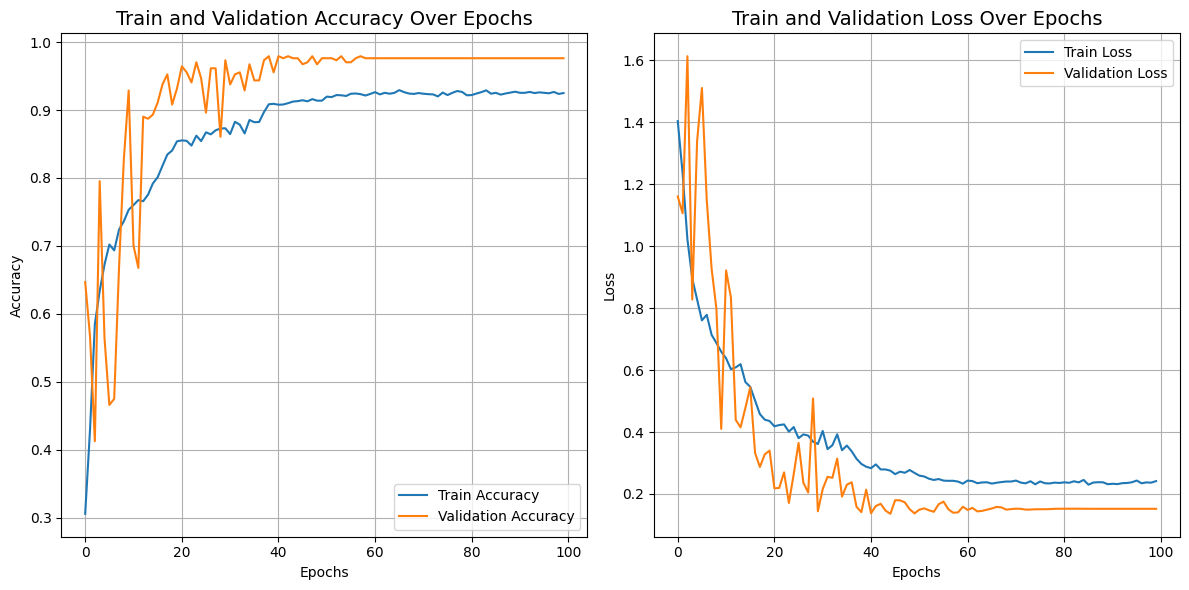

In [16]:
def run_experiment(model):
    

    model.compile(
        optimizer='adam',
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6, verbose=True)
    history = model.fit(
        x=X_resampled,
        y=Y_resampled,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback,model_rlr],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test, Y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(history):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_history(history)

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 626ms/step


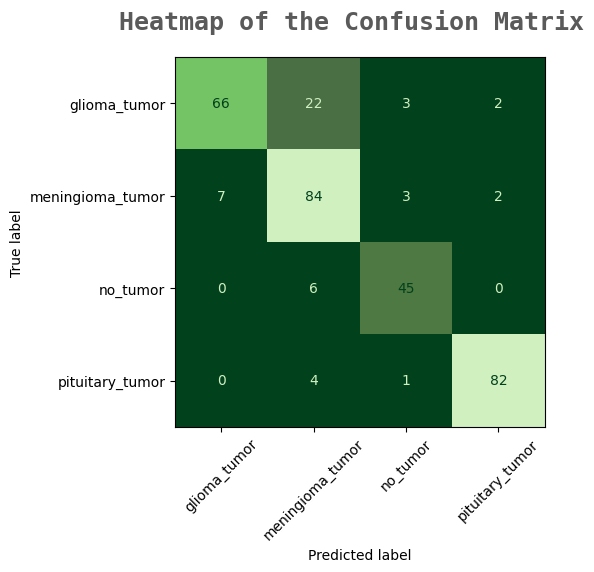

In [17]:

# Define custom color map (use the same as in your previous code)
custom_colors = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']
custom_cmap = matplotlib.colors.ListedColormap(custom_colors)
# Define colors_dark for styling the plot (use the same as in your previous code)
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
# Compute predictions (assuming you have y_true and y_pred from the ViT model)
y_pred_probs = vit_classifier.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Define labels
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a display object with the custom color map
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap=custom_cmap, ax=ax, colorbar=False)  # Disable the colorbar if desired

# Set the title and axis labels
fig.suptitle('Heatmap of the Confusion Matrix', size=18, fontweight='bold', fontname='monospace', color=colors_dark[1], alpha=0.8)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Save the figure
plt.savefig('CM_ViT.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [18]:
# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=labels))

Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.90      0.71      0.80        93
meningioma_tumor       0.72      0.88      0.79        96
        no_tumor       0.87      0.88      0.87        51
 pituitary_tumor       0.95      0.94      0.95        87

        accuracy                           0.85       327
       macro avg       0.86      0.85      0.85       327
    weighted avg       0.86      0.85      0.85       327

